NOTE: This notebook runs LogisticRegression without Lasso (L1) or Ridge (L2) regularization. For this you need SKlearn 0.21.3. 

For users who are to Python: you can check the version you have by entering 
                conda list 
in the Anaconda Prompt. To update an earlier version enter 
            conda update python 
in the Anaconda Prompt. 



In [1]:
# import packages
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score
from sklearn.metrics import precision_recall_curve, auc, average_precision_score

In [2]:
train = pd.read_excel('lendingclub_traindata.xlsx')
test = pd.read_excel('lendingclub_testdata.xlsx')

# 1 = good, 0 = default

# give column names
cols = ['home_ownership', 'income', 'dti', 'fico_low', 'loan_status']
train.columns = test.columns = cols

print(train.head())
print("--------------------------------")
print(test.head())

   home_ownership  income    dti  fico_low  loan_status
0               1  44.304  18.47       690            0
1               0  38.500  33.73       660            0
2               1  54.000  19.00       660            0
3               1  60.000  33.98       695            0
4               0  39.354  10.85       685            0
--------------------------------
   home_ownership  income    dti  fico_low  loan_status
0               1   127.0  10.94       675            0
1               1   197.0  15.64       710            0
2               1    25.5  28.75       670            0
3               1    80.0  20.16       660            0
4               0    57.0  30.60       675            0


For the purposes of this exercise, the dataset has already been split into train and test set. There are 8695 instances of training set and 5916 instances of test set with with four features and one target. The four features are home_ownership, income, dti and fico_low and the target is loan status that includes either fully paid or defaulted loans only. 

In [3]:
# remove target column to create feature only dataset
X_train = train.drop('loan_status', 1)
X_test = test.drop('loan_status', 1)

# store target column
y_train = train['loan_status']
y_test = test['loan_status']

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
X_train.columns

(8695, 4) (8695,) (5916, 4) (5916,)


Index(['home_ownership', 'income', 'dti', 'fico_low'], dtype='object')

In [4]:
majority_class = y_train.mode()[0]        # predict fully paid only
prediction = np.full(shape=y_train.shape, fill_value=majority_class)
accuracy_score(y_train, prediction)

0.8276020701552617

In [5]:
freq = y_train.value_counts()           # count frequency of different classes in loan status
freq/sum(freq)*100                      # get percentage of above

1    82.760207
0    17.239793
Name: loan_status, dtype: float64

In [6]:
lgstc_reg =  LogisticRegression(penalty="none", solver='newton-cg')     # create an instance of logistic regression

lgstc_reg.fit(X_train, y_train)                                                             # fit training data on logistic regression 

print(lgstc_reg.intercept_, lgstc_reg.coef_)                                                # get the coefficients of each features

[-6.56518725] [[ 0.13949599  0.00410667 -0.00112302  0.01125204]]


<br>
The bias is estimated as -6.56517476. The coefficient of the logistic regression are 0.13949599 for home_ownership, 0.0041 0667 for income, -0.00112303 for dti and 0.01125202 for fico_low. These are the weights (parameters) that maximizes the likelihood of producing our given data and hence gives us the least error in predicting our response variable.

The question of how to evaluate the model is of the utmost importance. This is where we will test the model's performance on an unseen test set and check the results of our chosen measure of success. This step is meant to be representative of how the model might perform in the real world.

In [7]:
y_pred = lgstc_reg.predict(X_test)                           # predict default loans based on test data set


<br> 
An analyst must decide on a criterion for predicting whether loan will be good or default. This involves specifying a threshold By default this threshold is set to 0.5, i.e., loans are separated into good and bad categories according to whether the probability of no default is greater or less than 0.5. However this does not work well for an imbalanced data set such as this. It would predict that all loans are good!We will look at the results for few other thresholds. 



In [11]:
THRESHOLD = [.75, .80, .85]
results = pd.DataFrame(columns=["THRESHOLD", "accuracy", "recall", "tnr", "fpr", "precision", "f1_score"]) # df to store results
results['THRESHOLD'] = THRESHOLD                                                                           # threshold column
             
j = 0                                                                                                      
for i in THRESHOLD:                                                                                        # iterate over each threshold    
    
    
    lgstc_reg.fit(X_train, y_train)                                                                        # fit data to model
    preds = np.where(lgstc_reg.predict_proba(X_test)[:,1] > i, 1, 0)                                       # if prob > threshold, predict 1
    
    cm = (confusion_matrix(y_test, preds,labels=[1, 0], sample_weight=None) / 5916 )*100                   # confusion matrix (in percentage)
    
    print('Confusion matrix for threshold =',i)
    print(cm)
    print(' ')      
    
    TP = cm[0][0]                                                                                          # True Positives
    FN = cm[0][1]                                                                                          # False Positives
    FP = cm[1][0]                                                                                          # True Negatives
    TN = cm[1][1]                                                                                          # False Negatives
        
    results.iloc[j,1] = accuracy_score(y_test, preds) 
    results.iloc[j,2] = recall_score(y_test, preds)
    results.iloc[j,3] = TN/(FP+TN)                                                                         # True negative rate
    results.iloc[j,4] = FP/(FP+TN)                                                                         # False positive rate
    results.iloc[j,5] = precision_score(y_test, preds)
    results.iloc[j,6] = f1_score(y_test, preds)
   
   
    j += 1

print('ALL METRICS')
print( results.T)

    
    
   

Confusion matrix for threshold = 0.75
[[77.5862069   4.5300879 ]
 [16.26098715  1.62271805]]
 
Confusion matrix for threshold = 0.8
[[55.34144692 26.77484787]
 [ 9.75321163  8.13049358]]
 
Confusion matrix for threshold = 0.85
[[28.65111562 53.46517918]
 [ 3.73563218 14.14807302]]
 
ALL METRICS
                   0         1         2
THRESHOLD       0.75       0.8      0.85
accuracy    0.792089  0.634719  0.427992
recall      0.944833   0.67394  0.348909
tnr        0.0907372  0.454631  0.791115
fpr         0.909263  0.545369  0.208885
precision   0.826729  0.850169  0.884656
f1_score    0.881844  0.751866  0.500443


<br>
We note here from the confusion matrix at threshold 0.75 that while the model is good at identifying good loans, however it isn't good at identifying the bad loans at all.

We also note that increasing the threshold results in decrease in overall accuracy. But the percentage of default loans identified as default is higher with increasing threshold. We know by now that maximizing the accuracy does not necessarily create the best model. Thus, lets look at some other metrics.

In [12]:
print( 'ALL METRICS' )
print( results.T )

ALL METRICS
                   0         1         2
THRESHOLD       0.75       0.8      0.85
accuracy    0.792089  0.634719  0.427992
recall      0.944833   0.67394  0.348909
tnr        0.0907372  0.454631  0.791115
fpr         0.909263  0.545369  0.208885
precision   0.826729  0.850169  0.884656
f1_score    0.881844  0.751866  0.500443


0.5
0.6019668412790937


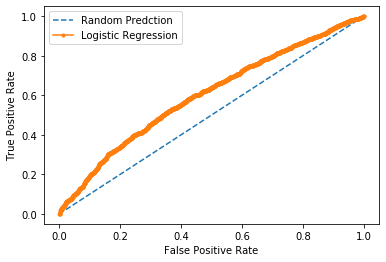

In [13]:
lr_prob=lgstc_reg.predict_proba(X_test)
lr_prob=lr_prob[:, 1]
ns_prob=[0 for _ in range(len(y_test))]
ns_auc=roc_auc_score(y_test, ns_prob)
lr_auc=roc_auc_score(y_test,lr_prob)
print(ns_auc)
print(lr_auc)
ns_fpr,ns_tpr,_=roc_curve(y_test,ns_prob)
lr_fpr,lr_tpr,_=roc_curve(y_test,lr_prob)

plt.plot(ns_fpr,ns_tpr,linestyle='--',label='Random Predction')
plt.plot(lr_fpr,lr_tpr,marker='.',label='Logistic Regression')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

<br>
Recall and true negative rate are also decreasing with increase in threshold rate. However, precision and false positive rate are increasing with increasing threshold. 